In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
climatedata=pd.read_csv(r"/content/drive/My Drive/qzvin_hourly_data.csv")
# Convert date to datetime and extract features
climatedata['date'] = pd.to_datetime(climatedata['date'])
climatedata['hour'] = climatedata['date'].dt.hour
climatedata['day'] = climatedata['date'].dt.day
climatedata['month'] = climatedata['date'].dt.month
climatedata['year'] = climatedata['date'].dt.year

#data preprocessing
print(climatedata.dtypes)
print(climatedata.head())
climatedata.isnull().sum()
climatedata.dropna(inplace=True)
climatedata.isnull().sum()
climatedata.drop(columns=['date'], inplace=True)

date                                datetime64[ns, UTC]
temperature_2m                                  float64
relative_humidity_2m                            float64
dew_point_2m                                    float64
apparent_temperature                            float64
precipitation                                   float64
rain                                            float64
snowfall                                        float64
snow_depth                                      float64
weather_code                                      int64
pressure_msl                                    float64
surface_pressure                                float64
cloud_cover                                     float64
cloud_cover_low                                   int64
cloud_cover_mid                                   int64
cloud_cover_high                                  int64
et0_fao_evapotranspiration                      float64
vapour_pressure_deficit                         

In [26]:
# Define target variable (modify based on your goal)
target_variable = 'temperature_2m'

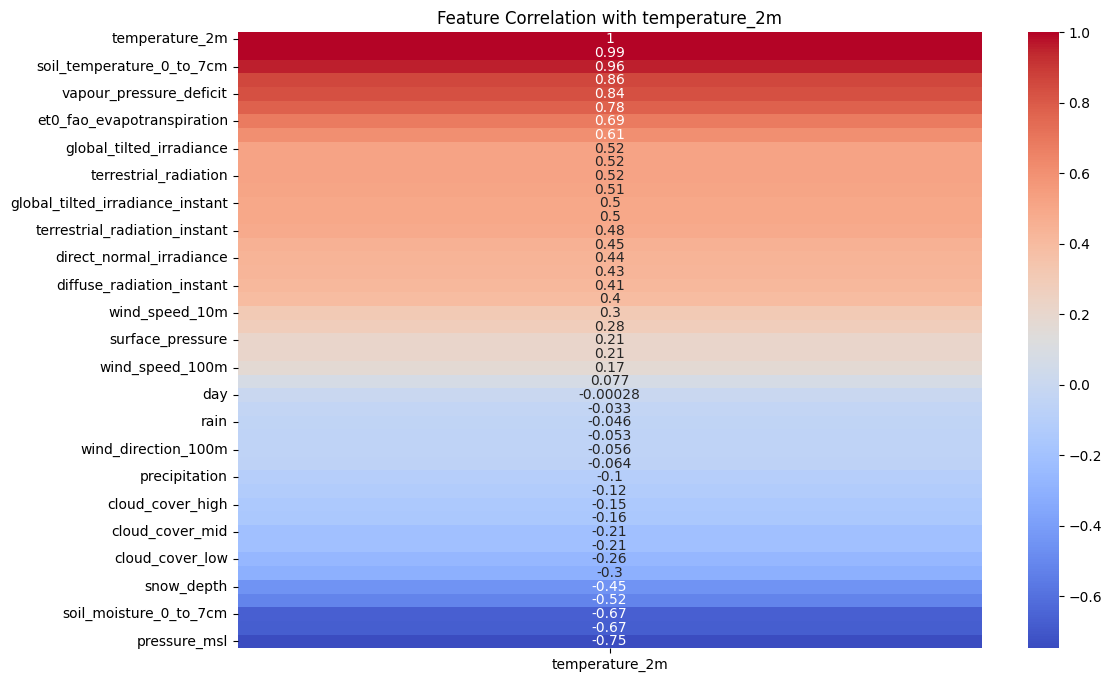

In [27]:
# Compute correlation matrix
corr_matrix = climatedata.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[[target_variable]].sort_values(by=target_variable, ascending=False), annot=True, cmap='coolwarm')
plt.title(f'Feature Correlation with {target_variable}')
plt.show()

In [28]:
# Select highly correlated features
correlated_features = corr_matrix[target_variable].abs().sort_values(ascending=False)
selected_features = correlated_features[correlated_features > 0.2].index.tolist()
selected_features.remove(target_variable)
print(selected_features)


['apparent_temperature', 'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm', 'vapour_pressure_deficit', 'soil_temperature_28_to_100cm', 'pressure_msl', 'et0_fao_evapotranspiration', 'relative_humidity_2m', 'soil_moisture_0_to_7cm', 'dew_point_2m', 'global_tilted_irradiance', 'shortwave_radiation', 'terrestrial_radiation', 'soil_moisture_7_to_28cm', 'direct_radiation', 'global_tilted_irradiance_instant', 'shortwave_radiation_instant', 'terrestrial_radiation_instant', 'snow_depth', 'diffuse_radiation', 'direct_normal_irradiance', 'direct_normal_irradiance_instant', 'diffuse_radiation_instant', 'wind_gusts_10m', 'cloud_cover', 'wind_speed_10m', 'soil_temperature_100_to_255cm', 'cloud_cover_low', 'weather_code', 'surface_pressure', 'month', 'cloud_cover_mid']


In [35]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
climatedata_scaled=scaler.fit_transform(climatedata)

In [29]:
# Feature selection using Random Forest
X = climatedata[selected_features]
y = climatedata[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
feature_importances = pd.Series(rf.feature_importances_, index=selected_features)

In [34]:
# Make Predictions
y_pred = rf.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.008461384717474063
R-squared: 0.9999265426397554


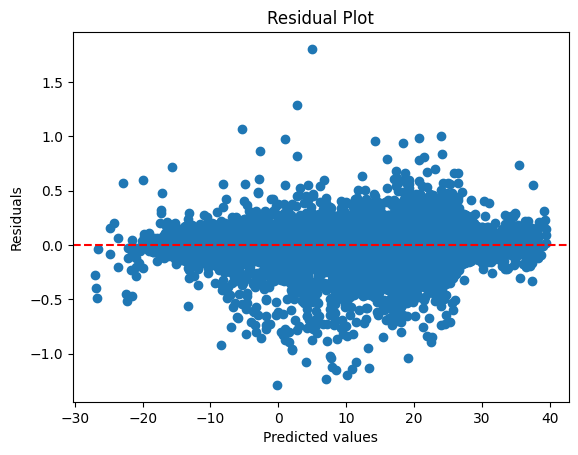

In [36]:


residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [37]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression


# Model
model = LinearRegression()

# 5-Fold Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# R-squared scores
r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

print("R² Scores on each fold:", r2_scores)
print("Average R² Score:", np.mean(r2_scores))


R² Scores on each fold: [0.999943   0.99994198 0.99994349 0.99994181 0.99994114]
Average R² Score: 0.9999422857303232


In [38]:


# Negative MSE scores (scikit-learn uses negative MSE for scoring)
mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')

# Convert to positive MSE
mse_scores = -mse_scores

print("MSE on each fold:", mse_scores)
print("Average MSE:", np.mean(mse_scores))

MSE on each fold: [0.00656598 0.00660579 0.0064942  0.00668425 0.00672584]
Average MSE: 0.0066152120044353415
